**Источник задачи**: Kaggle

**Суть задачи**: предсказать вероятность дефолта для заемщиков банка Home Credit. 

Классическая скоринговая задача, со стандартной для такого класса задач метрикой - $rocauc$ (переводится в "банковский" $gini$= $2*rocauc - 1$)


Предоставляются 7 источников информации:
    1. Заявочные данные
    2. Данные из Кредитного Бюро (на дату заявки)
    3. Данные из Кредитного Бюро: платежи помесячно (платежная дисциплина)
    4. Внутренние данные по Cash-кредитам - помесячные
    5. Внутренние данные по кредитным картам - помесячные
    6. Инфо о предыдущих заявках
    7. Детальные данные о платежах по внутренним кредитам

Решать задачу будем классическим методом - с помощью лог-регрессии построим скоринговую карту

In [20]:
# Импортируем необходимые библиотеки
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option("precision", 3)
pd.options.display.float_format = '{:20,.2f}'.format

In [ ]:
# Загрузим датасет

application_test = pd.read_csv('...\\application_test.csv') # заявочные данные для теста
application_train = pd.read_csv('...\\application_train.csv') # заявочные данные для обучения
bureau = pd.read_csv('...\\bureau.csv') # данные из Бюро Кредитных Историй
bureau_balance = pd.read_csv('...\\bureau_balance.csv') # платежные данные из БКИ
credit_card_balance = pd.read_csv('...\\credit_card_balance.csv') # внутренние данные по балансам кредитных карт
installments_payments = pd.read_csv('...\\installments_payments.csv') # платежныем данные по внутренним кредитам
pos_cash_balance = pd.read_csv('...\\POS_CASH_balance.csv') # внутренние данные по балансам POS/CASH-кредитов
previous_application = pd.read_csv('...\\previous_application.csv') # данные о предыдущих заявках

Сразу возникает желание собрать данные в одну большую таблицу - посмотрим на структуру таблиц

In [10]:
# заявочные данные
application_train.head(5).T

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
FLAG_OWN_REALTY,Y,N,Y,Y,Y
CNT_CHILDREN,0,0,0,0,0
AMT_INCOME_TOTAL,"202,500.00","270,000.00","67,500.00","135,000.00","121,500.00"
AMT_CREDIT,"406,597.50","1,293,502.50","135,000.00","312,682.50","513,000.00"
AMT_ANNUITY,"24,700.50","35,698.50","6,750.00","29,686.50","21,865.50"


In [11]:
# данные БКИ
bureau.head(5).T

,0,1,2,3,4
SK_ID_CURR,215354,215354,215354,215354,215354
SK_ID_BUREAU,5714462,5714463,5714464,5714465,5714466
CREDIT_ACTIVE,Closed,Active,Active,Active,Active
CREDIT_CURRENCY,currency 1,currency 1,currency 1,currency 1,currency 1
DAYS_CREDIT,-497,-208,-203,-203,-629
CREDIT_DAY_OVERDUE,0,0,0,0,0
DAYS_CREDIT_ENDDATE,-153.00,"1,075.00",528.00,NaN,"1,197.00"
DAYS_ENDDATE_FACT,-153.00,NaN,NaN,NaN,NaN
AMT_CREDIT_MAX_OVERDUE,NaN,NaN,NaN,NaN,"77,674.50"
CNT_CREDIT_PROLONG,0,0,0,0,0


In [12]:
# платежные данные БКИ
bureau_balance.head(5).T

,0,1,2,3,4
SK_ID_BUREAU,5715448,5715448,5715448,5715448,5715448
MONTHS_BALANCE,0,-1,-2,-3,-4
STATUS,C,C,C,C,C


In [13]:
# данные по кредитным картам
credit_card_balance.head(5).T

,0,1,2,3,4
SK_ID_PREV,2562384,2582071,1740877,1389973,1891521
SK_ID_CURR,378907,363914,371185,337855,126868
MONTHS_BALANCE,-6,-1,-7,-4,-1
AMT_BALANCE,56.97,"63,975.56","31,815.22","236,572.11","453,919.46"
AMT_CREDIT_LIMIT_ACTUAL,135000,45000,450000,225000,450000
AMT_DRAWINGS_ATM_CURRENT,0.00,"2,250.00",0.00,"2,250.00",0.00
AMT_DRAWINGS_CURRENT,877.50,"2,250.00",0.00,"2,250.00","11,547.00"
AMT_DRAWINGS_OTHER_CURRENT,0.00,0.00,0.00,0.00,0.00
AMT_DRAWINGS_POS_CURRENT,877.50,0.00,0.00,0.00,"11,547.00"
AMT_INST_MIN_REGULARITY,"1,700.33","2,250.00","2,250.00","11,795.76","22,924.89"


In [14]:
# платежные данные по внутренним кредитам
installments_payments.head(5).T

,0,1,2,3,4
SK_ID_PREV,"1,054,186.00","1,330,831.00","2,085,231.00","2,452,527.00","2,714,724.00"
SK_ID_CURR,"161,674.00","151,639.00","193,053.00","199,697.00","167,756.00"
NUM_INSTALMENT_VERSION,1.00,0.00,2.00,1.00,1.00
NUM_INSTALMENT_NUMBER,6.00,34.00,1.00,3.00,2.00
DAYS_INSTALMENT,"-1,180.00","-2,156.00",-63.00,"-2,418.00","-1,383.00"
DAYS_ENTRY_PAYMENT,"-1,187.00","-2,156.00",-63.00,"-2,426.00","-1,366.00"
AMT_INSTALMENT,"6,948.36","1,716.53","25,425.00","24,350.13","2,165.04"
AMT_PAYMENT,"6,948.36","1,716.53","25,425.00","24,350.13","2,160.59"


In [15]:
# данные по POS/CASH-кредитам
pos_cash_balance.head(5).T

,0,1,2,3,4
SK_ID_PREV,1803195,1715348,1784872,1903291,2341044
SK_ID_CURR,182943,367990,397406,269225,334279
MONTHS_BALANCE,-31,-33,-32,-35,-35
CNT_INSTALMENT,48.00,36.00,12.00,48.00,36.00
CNT_INSTALMENT_FUTURE,45.00,35.00,9.00,42.00,35.00
NAME_CONTRACT_STATUS,Active,Active,Active,Active,Active
SK_DPD,0,0,0,0,0
SK_DPD_DEF,0,0,0,0,0


In [16]:
# данные из предыдущих заявок
previous_application.head(5).T

,0,1,2,3,4
SK_ID_PREV,2030495,2802425,2523466,2819243,1784265
SK_ID_CURR,271877,108129,122040,176158,202054
NAME_CONTRACT_TYPE,Consumer loans,Cash loans,Cash loans,Cash loans,Cash loans
AMT_ANNUITY,"1,730.43","25,188.62","15,060.74","47,041.33","31,924.40"
AMT_APPLICATION,"17,145.00","607,500.00","112,500.00","450,000.00","337,500.00"
AMT_CREDIT,"17,145.00","679,671.00","136,444.50","470,790.00","404,055.00"
AMT_DOWN_PAYMENT,0.00,NaN,NaN,NaN,NaN
AMT_GOODS_PRICE,"17,145.00","607,500.00","112,500.00","450,000.00","337,500.00"
WEEKDAY_APPR_PROCESS_START,SATURDAY,THURSDAY,TUESDAY,MONDAY,THURSDAY
HOUR_APPR_PROCESS_START,15,11,11,7,9


Обработаем данные, сгруппируем по ID_заявки (SK_CURR_ID), соберем в большую витрину

In [22]:
# Платежные данные БКИ

# выбираем только активные статусы (нас не интересуют статусы "закрыто", "нет инфо" и т.д)
bureau_balance['ACTIVE_STATUS'] = bureau_balance['STATUS'].isin(['0', '1', '2', '3', '4', '5']).astype(int);
b_balance = bureau_balance[bureau_balance['ACTIVE_STATUS'] == 1];
# делаем несколько переменных по просрочкам
b_balance['0+'] = b_balance['STATUS'].isin(['1', '2', '3', '4', '5']).astype(int)
b_balance['30+'] = b_balance['STATUS'].isin(['2', '3', '4', '5']).astype(int)
b_balance['60+'] = b_balance['STATUS'].isin(['3', '4', '5']).astype(int)
b_balance['90+'] = b_balance['STATUS'].isin(['4', '5']).astype(int)
b_balance['30_6'] = (b_balance['STATUS'].isin(['2', '3', '4', '5']) & (b_balance['MONTHS_BALANCE'] >= -6)).astype(int)
b_balance['30_12'] = (b_balance['STATUS'].isin(['2', '3', '4', '5']) & (b_balance['MONTHS_BALANCE'] >= -12)).astype(int)
b_balance['90_12'] = (b_balance['STATUS'].isin(['4', '5']) & (b_balance['MONTHS_BALANCE'] >= -12)).astype(int)
b_balance['60_9'] = (b_balance['STATUS'].isin(['3', '4', '5']) & (b_balance['MONTHS_BALANCE'] >= -9)).astype(int)

# группируем по ID-договора БКИ, чтобы потом соединить с выборкой bureau
grouped = b_balance.groupby('SK_ID_BUREAU')

bb_30_flg = grouped['30+'].max()
bb_60_flg = grouped['60+'].max()
bb_90_flg = grouped['90+'].max()
bb_0_flg = grouped['0+'].max()
bb_30_6_flg = grouped['30_6'].max()
bb_30_12_flg = grouped['30_12'].max()
bb_60_9_flg = grouped['60_9'].max()
bb_90_12_flg = grouped['90_12'].max()

# соединяем в таблицу и приклеиваем к выборке bureau
bb_final = pd.concat([bb_30_flg, bb_60_flg, bb_0_flg, bb_90_flg, bb_30_6_flg, bb_30_12_flg, \
                      bb_60_9_flg, bb_90_12_flg], axis = 1)
bureau = bureau.join(bb_final, on = 'SK_ID_BUREAU');

In [23]:
# Балансовые данные БКИ

# проставим флаг наличия инфо из БКИ
bureau['HAS_PAYMENT_INFO'] = 1 - bureau['0+'].isna().astype(int)

# флаги наличия активного кредита, кредитной карты, микрокредита
bureau = bureau.fillna(0)
bureau['active_credit'] = (bureau['CREDIT_ACTIVE'] == 'Active').astype(int)
bureau['credit_card_flg'] = (bureau['CREDIT_TYPE'] == 'Credit card').astype(int)
bureau['microloan_flg'] = (bureau['CREDIT_TYPE'] == 'Microloan').astype(int)

# группируем, делаем разные переменные, объединяем в финальную таблицу
grouped = bureau.groupby('SK_ID_CURR')

b_total_credits_cnt = grouped['SK_ID_CURR'].count()
b_active_credits_cnt = grouped['active_credit'].sum()
b_last_credit_days = grouped['DAYS_CREDIT'].max()
b_first_credit_days = grouped['DAYS_CREDIT'].min()
b_max_overdue_days = grouped['CREDIT_DAY_OVERDUE'].max()
b_last_end_credit_days = grouped['DAYS_ENDDATE_FACT'].max()
b_first_end_credit_days = grouped['DAYS_ENDDATE_FACT'].min()
b_max_overdue_amt = grouped['AMT_CREDIT_MAX_OVERDUE'].sum()
b_prolongation_cnt = grouped['CNT_CREDIT_PROLONG'].max()
b_debt_ratio = grouped['AMT_CREDIT_SUM_DEBT'].sum()/grouped['AMT_CREDIT_SUM'].sum() # доля остатка задолженности
b_overdue_debt_ratio = grouped['AMT_CREDIT_SUM_OVERDUE'].sum()/grouped['AMT_CREDIT_SUM_DEBT'].sum()
b_last_info_days = grouped['DAYS_CREDIT_UPDATE'].max()
b_annuity_bureau_sum = grouped['AMT_ANNUITY'].sum()
b_credit_card_cnt = grouped['credit_card_flg'].sum()
b_microloan_flg = grouped['microloan_flg'].max()
b_del_0_flg = grouped['0+'].max()
b_del_30_flg = grouped['30+'].max()
b_del_60_flg = grouped['60+'].max()
b_del_90_flg = grouped['90+'].max()
b_del_30_6_flg = grouped['30_6'].max()
b_del_30_12_flg = grouped['30_12'].max()
b_del_60_9_flg = grouped['60_9'].max()
b_del_90_12_flg = grouped['90_12'].max()
b_del_0_sum = grouped['0+'].sum()
b_del_30_sum = grouped['30+'].sum()
b_del_60_sum = grouped['60+'].sum()
b_del_90_sum = grouped['90+'].sum()
b_del_30_6_sum = grouped['30_6'].sum()
b_del_30_12_sum = grouped['30_12'].sum()
b_del_60_9_sum = grouped['60_9'].sum()
b_del_90_12_sum = grouped['90_12'].sum()

b_final = pd.concat([
    b_total_credits_cnt, b_active_credits_cnt, b_last_credit_days, b_first_credit_days, b_max_overdue_days, b_last_end_credit_days
    ,b_first_end_credit_days,b_max_overdue_amt,b_prolongation_cnt,b_debt_ratio,b_overdue_debt_ratio,b_last_info_days,
    b_annuity_bureau_sum,b_credit_card_cnt,b_microloan_flg,b_del_0_flg,b_del_30_flg,b_del_60_flg,b_del_90_flg,
    b_del_30_6_flg,b_del_30_12_flg,b_del_60_9_flg,b_del_90_12_flg,b_del_0_sum,b_del_30_sum,b_del_60_sum,b_del_90_sum
    ,b_del_30_6_sum,b_del_30_12_sum,b_del_60_9_sum,b_del_90_12_sum
], axis = 1)

b_final.columns = ['total_credit_cnt',          'active_credit_cnt',
                  'last_credit_days',            'first_credit_days',
           'max_overdue_days',      'last_end_credit_days',
            'first_end_credit_days', 'max_overdue_amt',
           'prolongation_cnt',                        'debt_ratio',
                              'overdue_debt_ratio',     'last_info_days',
                  'annuity_bureau_sum',        'credit_card_cnt',
                'microloan_flg',                     '0+',
                          '30+',                    '60+',
                          '90+',                   '30_6',
                        '30_12',                   '60_9',
                        '90_12',                     '0+_sum',
                          '30+_sum',                    '60+_sum',
                          '90+_sum',                   '30_6_sum',
                        '30_12_sum',                   '60_9_sum',
                        '90_12_sum']

In [24]:
# данные по POS/CASH-кредитам

# аналогично, делаем переменные, группируем
pc_balance = pos_cash_balance

pc_balance['30+'] = (pc_balance['SK_DPD'] >= 30).astype(int)
pc_balance['60+'] = (pc_balance['SK_DPD'] >= 60).astype(int)
pc_balance['90+'] = (pc_balance['SK_DPD'] >= 90).astype(int)
pc_balance['30_6'] = ((pc_balance['SK_DPD'] >= 30) & (pc_balance['MONTHS_BALANCE'] >= -6)).astype(int)
pc_balance['30_12'] = ((pc_balance['SK_DPD'] >= 30) & (pc_balance['MONTHS_BALANCE'] >= -12)).astype(int)
pc_balance['60_9'] = ((pc_balance['SK_DPD'] >= 60) & (pc_balance['MONTHS_BALANCE'] >= -9)).astype(int)
pc_balance['90_12'] = ((pc_balance['SK_DPD'] >= 90) & (pc_balance['MONTHS_BALANCE'] >= -12)).astype(int)

pc_balance['30+_def'] = (pc_balance['SK_DPD_DEF'] >= 30).astype(int)
pc_balance['60+_def'] = (pc_balance['SK_DPD_DEF'] >= 60).astype(int)
pc_balance['90+_def'] = (pc_balance['SK_DPD_DEF'] >= 90).astype(int)
pc_balance['30_6_def'] = ((pc_balance['SK_DPD_DEF'] >= 30) & (pc_balance['MONTHS_BALANCE'] >= -6)).astype(int)
pc_balance['30_12_def'] = ((pc_balance['SK_DPD_DEF'] >= 30) & (pc_balance['MONTHS_BALANCE'] >= -12)).astype(int)
pc_balance['60_9_def'] = ((pc_balance['SK_DPD_DEF'] >= 60) & (pc_balance['MONTHS_BALANCE'] >= -9)).astype(int)
pc_balance['90_12_def'] = ((pc_balance['SK_DPD_DEF'] >= 90) & (pc_balance['MONTHS_BALANCE'] >= -12)).astype(int)

grouped = pc_balance.groupby(['SK_ID_PREV', 'SK_ID_CURR'])

pc_30 = grouped['30+'].max()
pc_60 = grouped['60+'].max()
pc_90 = grouped['90+'].max()
pc_30_6 = grouped['30_6'].max()
pc_30_12 = grouped['30_12'].max()
pc_60_9 = grouped['60_9'].max()
pc_90_12 = grouped['90_12'].max()

pc_30_def = grouped['30+_def'].max()
pc_60_def = grouped['60+_def'].max()
pc_90_def = grouped['90+_def'].max()
pc_30_6_def = grouped['30_6_def'].max()
pc_30_12_def = grouped['30_12_def'].max()
pc_60_9_def = grouped['60_9_def'].max()
pc_90_12_def = grouped['90_12_def'].max()

pc_balance_1 = pd.concat([
    pc_30, pc_60, pc_90, pc_30_6, pc_30_12, pc_60_9, pc_90_12, pc_30_def, pc_60_def, pc_90_def, pc_30_6_def
    ,pc_30_12_def, pc_60_9_def, pc_90_12_def
], axis = 1)

pc_balance_final = pc_balance_1.groupby('SK_ID_CURR').max()

In [25]:
# Данные по кредитным картам

cc_balance = credit_card_balance

cc_balance['util'] = cc_balance['AMT_BALANCE']/cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] # утилизация лимита 

cc_balance['30+'] = (cc_balance['SK_DPD'] >= 30).astype(int)
cc_balance['30_12'] = ((cc_balance['SK_DPD'] >= 30) & (cc_balance['MONTHS_BALANCE'] >= -12)).astype(int)
cc_balance['30+_def'] = (cc_balance['SK_DPD_DEF'] >= 30).astype(int)
cc_balance['30_12_def'] = ((cc_balance['SK_DPD_DEF'] >= 30) & (cc_balance['MONTHS_BALANCE'] >= -12)).astype(int)

# доля погашения обятельного платежа
cc_balance['payment_util'] = cc_balance['AMT_PAYMENT_CURRENT']/cc_balance['AMT_INST_MIN_REGULARITY'] 

g1 = cc_balance[cc_balance['MONTHS_BALANCE'] >= -6].fillna(0).groupby(['SK_ID_PREV', 'SK_ID_CURR'])
util = g1['AMT_BALANCE'].sum()/g1['AMT_CREDIT_LIMIT_ACTUAL'].sum()
payment_util = g1['AMT_PAYMENT_CURRENT'].sum()/g1['AMT_INST_MIN_REGULARITY'].sum()

# количество и доля снятий в банкоматах
cc_atm_cnt = g1['CNT_DRAWINGS_ATM_CURRENT'].sum()
cc_atm_amt = g1['AMT_DRAWINGS_ATM_CURRENT'].sum()/g1['AMT_DRAWINGS_CURRENT'].sum()

payment = g1['AMT_PAYMENT_CURRENT'].mean()

g2 = cc_balance.fillna(0).groupby(['SK_ID_PREV', 'SK_ID_CURR'])
cc_30 = g2['30+'].max()
cc_30_12 = g2['30_12'].max()
cc_30_def = g2['30+_def'].max()
cc_30_12_def = g2['30_12_def'].max()

cc_balance_1 = pd.concat([util, payment_util, payment, cc_atm_cnt, cc_atm_amt, cc_30, cc_30_12, cc_30_def, cc_30_12_def], axis = 1)
cc_balance_1.columns = ['util', 'payment_util', 'payment','atm_cnt', 'atm_amt', '30+', 
                        '30_12', '30_def', '30_12_def']

g3 = cc_balance_1.fillna(0).replace(np.inf, 0).groupby('SK_ID_CURR')

cc_cnt = g3['30+'].count()
cc_util = g3['util'].mean()
cc_payment_util = g3['payment_util'].mean()
cc_payment = g3['payment'].sum()
cc_atm_cnt = g3['atm_cnt'].sum()
cc_atm_amt = g3['atm_amt'].sum()
cc_30 = g3['30+'].max()
cc_30_12 = g3['30_12'].max()
cc_30_def = g3['30_def'].max()
cc_30_12_def = g3['30_12_def'].max()

cc_balance_final = pd.concat([cc_cnt, cc_util, cc_payment_util, cc_payment, cc_atm_cnt, cc_atm_amt, cc_30
                             ,cc_30_12, cc_30_def, cc_30_12_def], axis = 1)
cc_balance_final.columns = ['cc_cnt', 'util', 'payment_util', 'payment', 'atm_cnt', 'atm_amt', '30+', '30_12', '30_def', '30_12_def']

In [26]:
# Информация из предыдущей заявки

# сначала посчитаем количество поданных заявления (и отказов по ним) за 3, 6, 12 месяцев
pa = previous_application

pa['reject'] = (pa['NAME_CONTRACT_STATUS'] == 'Refused').astype(int)
pa_app_cnt_3m = pa[pa['DAYS_DECISION'] >= -90].groupby('SK_ID_CURR')['SK_ID_PREV'].count()
pa_app_cnt_6m = pa[pa['DAYS_DECISION'] >= -120].groupby('SK_ID_CURR')['SK_ID_PREV'].count()
pa_app_cnt_12m = pa[pa['DAYS_DECISION'] >= -365].groupby('SK_ID_CURR')['SK_ID_PREV'].count()

pa_reject_3m = pa[pa['DAYS_DECISION'] >= -90].groupby('SK_ID_CURR')['reject'].sum()
pa_reject_6m = pa[pa['DAYS_DECISION'] >= -120].groupby('SK_ID_CURR')['reject'].sum()
pa_reject_12m = pa[pa['DAYS_DECISION'] >= -365].groupby('SK_ID_CURR')['reject'].sum()

pa_concat = pd.concat([pa_app_cnt_3m, pa_app_cnt_6m, pa_app_cnt_12m, pa_reject_3m, pa_reject_6m, pa_reject_12m], axis = 1)
pa_concat.columns = ['app_cnt_3m', 'app_cnt_6m', 'app_cnt_12m', 'rejects_3m', 'rejects_6m', 'rejects_12m']

# остальную информацию скопируем только с самой последней заявки
p_test = pa.sort_values(by = 'DAYS_DECISION', ascending = False).groupby('SK_ID_CURR').cumcount() + 1
pa['#'] = p_test
pa_final = pa[pa['#'] == 1].join(pa_concat, on = 'SK_ID_CURR')

In [27]:
# пометим собранные переменные префиксом источника и соберем большую витрину

b_final.columns = 'b_' + b_final.columns
pc_balance_final.columns = 'pc_' + pc_balance_final.columns
cc_balance_final.columns = 'cc_' + cc_balance_final.columns
pa_final.columns = 'pa_' + pa_final.columns

application_total_data = application_train
application_total_data.columns = 'app_' + application_train.columns
application_total_data = application_total_data.merge(b_final, how = 'left', left_on = 'app_SK_ID_CURR', right_index = True)
application_total_data = application_total_data.merge(pc_balance_final, how = 'left', left_on = 'app_SK_ID_CURR', right_index = True)
application_total_data = application_total_data.merge(cc_balance_final, how = 'left', left_on = 'app_SK_ID_CURR', right_index = True)
application_total_data = application_total_data.merge(pa_final, how = 'left', left_on = 'app_SK_ID_CURR', right_on = 'pa_SK_ID_CURR')

In [29]:
# теперь создадим несколько новых перменных

# DTI - кредитная нагрузка (отношение суммы платежей по обязательствам к доходу; высокое значение означает, что клиент 
# закредитован, и, возможно стоит осторожнее подходить к кредитованию таких клиентов)
application_total_data['m_DTI'] = (application_total_data['app_AMT_ANNUITY'].fillna(0)
                                 + application_total_data['b_annuity_bureau_sum'].fillna(0)
                                 + application_total_data['cc_payment'].fillna(0)
                                )/application_total_data['app_AMT_INCOME_TOTAL'].fillna(100000)

# Входящий DTI - кредитная нагрузка без учета выданного кредита
application_total_data['m_DTI_in'] = (
                                  application_total_data['b_annuity_bureau_sum'].fillna(0)
                                 + application_total_data['cc_payment'].fillna(0)
                                )/application_total_data['app_AMT_INCOME_TOTAL'].fillna(100000)

# Доля платежа по выданному кредиту в доходе
application_total_data['m_DTI_pay'] = application_total_data['app_AMT_ANNUITY'].fillna(0)\
                                /application_total_data['app_AMT_INCOME_TOTAL'].fillna(100000)

# Отношение стоимости "цели кредита" к сумме кредита
application_total_data['m_CREDIT_TO_GOOD'] = application_total_data['app_AMT_GOODS_PRICE'].fillna(0)\
                                            /application_total_data['app_AMT_CREDIT']

# Доля действующих кредитов
application_total_data['m_active_credit_part'] = application_total_data['b_active_credit_cnt'].fillna(0)\
                                                /application_total_data['b_total_credit_cnt'].fillna(1)\

# Удовлетворенность предыдущим кредитом
application_total_data['m_prev_satisfactory'] = application_total_data['pa_AMT_CREDIT'].fillna(0)\
                                                /application_total_data['pa_AMT_APPLICATION'].fillna(100000)
                                                
# Отношение стоимости "цели кредита" к сумме предыдущего кредита  
application_total_data['m_prev_CREDIT_TO_GOOD'] = application_total_data['pa_AMT_GOODS_PRICE'].fillna(0)\
                                            /application_total_data['pa_AMT_CREDIT'].fillna(100000)

#### Обработка данных и модель

Выборка в "сыром" виде готова.
Далее остается обработать переменные и обучить модель

Обработка будет зависеть от типа используемой модели. Так, например, для логистической регрессии переменные должны быть числовыми и отнормированными.

Будем использовать скоринговый подход:
1. Сгруппируем переменные в бины (binning, для этого есть отдельные библиотеки, но здесь сделаем вручную, по-простому)
2. По каждой переменной посчитаем WOE-таблицу (*weight of evidence*), IV (*information value*)
3. Отберем переменные с IV >= 0.05 (стандартная граница, можно менять в зависимости от задачи)
4. По каждой переменной заменим бины на соответствующие им woe-значения
5. Обучим логистическую регрессию на получившейся выборке

###### Обработка

Исходя из описанного выше подхода, будем использовать следующую логику: 
    1. для категориальных переменных - значения, содержащие малое количество наблюдений, схлопнем в один бин
    2. для численных переменных - автоматически разобьем на 10 бинов с равным количеством наблюдений

###### Категориальные переменные
посмотрим на количество уникальных значений

In [31]:
app_data_total = application_total_data

app_data_total.select_dtypes(include = 'object').nunique()

app_NAME_CONTRACT_TYPE             2
app_CODE_GENDER                    3
app_FLAG_OWN_CAR                   2
app_FLAG_OWN_REALTY                2
app_NAME_TYPE_SUITE                7
app_NAME_INCOME_TYPE               8
app_NAME_EDUCATION_TYPE            5
app_NAME_FAMILY_STATUS             6
app_NAME_HOUSING_TYPE              6
app_OCCUPATION_TYPE               18
app_WEEKDAY_APPR_PROCESS_START     7
app_ORGANIZATION_TYPE             58
app_FONDKAPREMONT_MODE             4
app_HOUSETYPE_MODE                 3
app_WALLSMATERIAL_MODE             7
app_EMERGENCYSTATE_MODE            2
pa_NAME_CONTRACT_TYPE              4
pa_WEEKDAY_APPR_PROCESS_START      7
pa_FLAG_LAST_APPL_PER_CONTRACT     2
pa_NAME_CASH_LOAN_PURPOSE         25
pa_NAME_CONTRACT_STATUS            4
pa_NAME_PAYMENT_TYPE               4
pa_CODE_REJECT_REASON              9
pa_NAME_TYPE_SUITE                 7
pa_NAME_CLIENT_TYPE                4
pa_NAME_GOODS_CATEGORY            26
pa_NAME_PORTFOLIO                  5
p

Разберем пару переменных вручную: тип работы (OCCUPATION_TYPE), тип организации (ORGANIZATION_TYPE)

In [33]:
# OCCUPATION_TYPE
df = app_data_total.groupby('app_OCCUPATION_TYPE')['app_TARGET'].agg(['count', 'mean']).sort_values(by = 'mean')
df

,count,mean
app_OCCUPATION_TYPE,,
Accountants,9813,0.05
High skill tech staff,11380,0.06
Managers,21371,0.06
Core staff,27570,0.06
HR staff,563,0.06
IT staff,526,0.06
Private service staff,2652,0.07
Medicine staff,8537,0.07
Secretaries,1305,0.07


Желательно группировать так, чтобы среднее значение по таргету было похоже, то есть например сгруппировать _"HR staff" + "IT staff"_ - можно, но _"HR staff" + "Waiters/barmen staff"_ лучше не группировать. Исходя из таблицы, получаются вполне интуитивные группы 

In [34]:
df.loc[df.index[0:4], 'app_OCCUPATION_TYPE_GROUP'] = ' / '.join(df.index[0:4])
df.loc[df.index[4:10], 'app_OCCUPATION_TYPE_GROUP'] = ' / '.join(df.index[4:10])
df.loc[df.index[[10,12,14,15,16,17]], 'app_OCCUPATION_TYPE_GROUP'] = ' / '.join(df.index[[10,12,14,15,16,17]])
df.loc[df['app_OCCUPATION_TYPE_GROUP'].isna(), 'app_OCCUPATION_TYPE_GROUP'] = df[df['app_OCCUPATION_TYPE_GROUP'].isna()].index

Получилась такая группировка:

In [35]:
app_data_total = app_data_total.join(df[['app_OCCUPATION_TYPE_GROUP']], on = 'app_OCCUPATION_TYPE');
df

,count,mean,app_OCCUPATION_TYPE_GROUP
app_OCCUPATION_TYPE,,,
Accountants,9813,0.05,Accountants / High skill tech staff / Managers...
High skill tech staff,11380,0.06,Accountants / High skill tech staff / Managers...
Managers,21371,0.06,Accountants / High skill tech staff / Managers...
Core staff,27570,0.06,Accountants / High skill tech staff / Managers...
HR staff,563,0.06,HR staff / IT staff / Private service staff / ...
IT staff,526,0.06,HR staff / IT staff / Private service staff / ...
Private service staff,2652,0.07,HR staff / IT staff / Private service staff / ...
Medicine staff,8537,0.07,HR staff / IT staff / Private service staff / ...
Secretaries,1305,0.07,HR staff / IT staff / Private service staff / ...


In [36]:
# ORGANIZATION_TYPE

df = app_data_total.groupby('app_ORGANIZATION_TYPE')['app_TARGET'].agg(['count', 'mean']).sort_values(by = 'count', ascending = False)
df.loc[df[df['count'] < 15000].index, 'app_ORGANIZATION_TYPE_GROUP'] = 'Other_2'
df.loc[df['app_ORGANIZATION_TYPE_GROUP'].isna(), 'app_ORGANIZATION_TYPE_GROUP'] = df[df['app_ORGANIZATION_TYPE_GROUP'].isna()].index
app_data_total = app_data_total.join(df[['app_ORGANIZATION_TYPE_GROUP']], on = 'app_ORGANIZATION_TYPE');

В данном случае мы просто сгруппировали бины со значениями менее 15 тыс. в отдельную группу _"Other_2"_.
Не самый умный подход, здесь можно было потратить время и сгруппировать по смыслу и по среднему таргету

In [38]:
df

,count,mean,app_ORGANIZATION_TYPE_GROUP
app_ORGANIZATION_TYPE,,,
Business Entity Type 3,67992,0.09,Business Entity Type 3
XNA,55374,0.05,XNA
Self-employed,38412,0.10,Self-employed
Other,16683,0.08,Other
Medicine,11193,0.07,Other_2
Business Entity Type 2,10553,0.09,Other_2
Government,10404,0.07,Other_2
School,8893,0.06,Other_2
Trade: type 7,7831,0.09,Other_2


In [ ]:
# убираем детальные переменные
app_data_total = app_data_total.drop(['app_OCCUPATION_TYPE', 'app_ORGANIZATION_TYPE'], axis = 1)

Для остальных категориальных переменных будем использовать следующий алгоритм:
    1. Выделим бины с количеством наблюдений менее 10 тыс (должно быть достаточно большое число, во-первых, для того, чтобы накопилось достаточно значений целевой переменной, а во-вторых, для избежания переобучения) и выделим в группу Other
    2. Если группа _Other_ получилась менее 10 тыс., промаркируем ее именем самого крупного бина в этой переменной

In [39]:
# выбираем категориальные переменные
object_cols = app_data_total.select_dtypes(include = 'object').columns
app_data_total[object_cols] = app_data_total[object_cols].fillna('N/A')
# строим Датафрейм со статистикой для отбора переменных
df = pd.DataFrame([[col, app_data_total[col].value_counts().min()
                    , app_data_total[col].value_counts().max()
                    , app_data_total[col].nunique()
                   ,(app_data_total[col].value_counts() > 10000).sum()] for col in object_cols])
df.columns = ['col', 'min_cnt', 'max_cnt', 'n_unique', 'good_group']

# для бинов размером менее 10 тыс, ставим метку Other
for col in df[df['n_unique'] > df['good_group']]['col'].values:
    app_data_total.loc[app_data_total[col].isin(
        list(app_data_total[col].value_counts()[app_data_total[col].value_counts() < 10000].index)), col] = 'Other'
    
df = pd.DataFrame([[col, app_data_total[col].value_counts().min()
                    , app_data_total[col].value_counts().max()
                    , app_data_total[col].nunique()
                   ,(app_data_total[col].value_counts() > 10000).sum()] for col in object_cols])
df.columns = ['col', 'min_cnt', 'max_cnt', 'n_unique', 'good_group']

# для бинов Other с менее 10 тыс наблюдений, ставим метку по самому крупному бину
for col in df[df['n_unique'] > df['good_group']]['col'].values:
    app_data_total.loc[app_data_total[col] == 'Other', col] = app_data_total[col].value_counts().index[0]
    
df = pd.DataFrame([[col, app_data_total[col].value_counts().min()
                    , app_data_total[col].value_counts().max()
                    , app_data_total[col].nunique()
                   ,(app_data_total[col].value_counts() > 10000).sum()] for col in object_cols])
df.columns = ['col', 'min_cnt', 'max_cnt', 'n_unique', 'good_group']

In [40]:
# уберем выбросы и пустоты
app_data_total = app_data_total.replace(np.inf, 0).fillna(0)

###### Численные переменные

Отбираем, делим на две части по количеству уникальных значений. Для больших - делим на 10 бинов, для небольших - на 5

Исходные переменные сохраним с постфиксом "_as_is"

In [41]:
num_cols = app_data_total.dtypes[~(app_data_total.dtypes == 'object')].index
df = pd.DataFrame([[col, app_data_total[col].nunique()] for col in num_cols])
df.columns = ['col', 'n_unique']

num_1_cols = df[(df['n_unique'] >= 4) & (df['n_unique'] < 20)]['col'].values
num_2_cols = df[df['n_unique'] >= 20]['col'].values[1:]

# при разбиении на бины, возможны случаи дублирования границ интервалов, тогда pandas будет ругаться
# чтобы этого избежать, добавим параметр duplicates = 'drop'
for col in num_1_cols:
    app_data_total[col + '_as_is'] = app_data_total[col]
    app_data_total[col] = pd.qcut(app_data_total[col], 5, duplicates = 'drop')
for col in num_2_cols:
    app_data_total[col + '_as_is'] = app_data_total[col]
    app_data_total[col] = pd.qcut(app_data_total[col], 10, duplicates = 'drop')

Напишем функцию для расчета WOE-таблицы

Сохраним IV всех переменных в промежуточную таблицу

In [107]:
# общее количество хороших и плохих исходов
app_data_total['y_good'] = (app_data_total['app_TARGET'] == 0).sum()
app_data_total['y_bad'] = (app_data_total['app_TARGET'] == 1).sum()

def IV(col):
    df = app_data_total.groupby(col).agg({'app_TARGET': ['count', lambda x: len(x) - sum(x), 'sum'], 'y_good': 'first'
                                                 , 'y_bad': 'first'})
    df.columns = ['count', 'good', 'bad', 'total_good', 'total_bad']
    df['distr_good'] = df['good']/df['total_good']
    df['distr_bad'] = df['bad']/df['total_bad']
    df[col + '_woe'] = np.log(df['distr_good']/df['distr_bad'])
    df['IV'] = (df['distr_good'] - df['distr_bad']) * df[col + '_woe']
    return [df, df['IV'].sum()]

# пробегаем по всем сгруппированным переменным
IVs = [[col, IV(col)[1]] for col in app_data_total.columns[~app_data_total.columns.str.contains('as_is')].drop(
    ['app_SK_ID_CURR', 'app_TARGET', 'y_good', 'y_bad'])]

df = pd.DataFrame(IVs)
df.columns = ['col_name', 'IV']
df.sort_values(by = 'IV', ascending = False)
df.replace(np.inf, np.nan, inplace = True)

In [108]:
df[df['IV'] >= 0.05].sort_values(by = 'IV', ascending = False)

,col_name,IV
41,app_EXT_SOURCE_3,0.32
40,app_EXT_SOURCE_2,0.30
39,app_EXT_SOURCE_1,0.11
16,app_DAYS_EMPLOYED,0.10
8,app_AMT_GOODS_PRICE,0.09
15,app_DAYS_BIRTH,0.08
122,b_last_credit_days,0.08
123,b_first_credit_days,0.07
223,m_CREDIT_TO_GOOD,0.07
126,b_first_end_credit_days,0.07


##### График значимости переменных

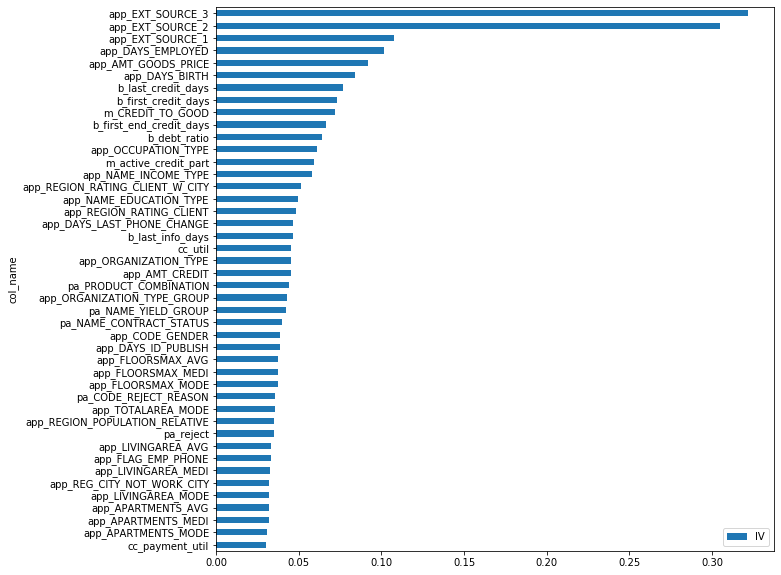

In [119]:
df[df['IV'] >= 0.03].sort_values(by = 'IV', ascending = True).set_index('col_name').plot(kind = 'barh', figsize = (10,10));

Итак, шорт-лист переменных готов. 

Заменим бины на соответствующие WOE-значения

In [48]:
# финальный набор
final_cols = df[df['IV'] >= 0.05]['col_name'].values
app_data_woe = app_data_total[final_cols]

# заменяем бины на WOE
for col in final_cols:
    app_data_woe = app_data_woe.join(IV(col)[0][col + '_woe'], on = col)

Проверим взаимную корреляцию

In [52]:
df = app_data_woe[final_cols + '_woe'].corr()
df

,app_AMT_GOODS_PRICE_woe,app_NAME_INCOME_TYPE_woe,app_DAYS_BIRTH_woe,app_DAYS_EMPLOYED_woe,app_OCCUPATION_TYPE_woe,app_REGION_RATING_CLIENT_W_CITY_woe,app_EXT_SOURCE_1_woe,app_EXT_SOURCE_2_woe,app_EXT_SOURCE_3_woe,b_last_credit_days_woe,b_first_credit_days_woe,b_first_end_credit_days_woe,b_debt_ratio_woe,m_CREDIT_TO_GOOD_woe,m_active_credit_part_woe
app_AMT_GOODS_PRICE_woe,1.00,0.04,0.09,0.08,0.06,0.05,0.08,0.09,0.09,0.05,0.07,0.07,0.04,0.15,0.05
app_NAME_INCOME_TYPE_woe,0.04,1.00,0.49,0.37,0.41,0.04,0.05,0.04,0.09,0.02,0.05,0.04,0.05,0.03,0.03
app_DAYS_BIRTH_woe,0.09,0.49,1.00,0.48,0.25,0.01,0.13,0.09,0.18,0.07,0.18,0.16,0.12,0.02,0.09
app_DAYS_EMPLOYED_woe,0.08,0.37,0.48,1.00,0.24,-0.02,0.08,0.08,0.16,0.06,0.19,0.17,0.09,0.03,0.09
app_OCCUPATION_TYPE_woe,0.06,0.41,0.25,0.24,1.00,0.02,0.12,0.06,0.04,0.01,0.05,0.04,0.02,0.06,0.02
app_REGION_RATING_CLIENT_W_CITY_woe,0.05,0.04,0.01,-0.02,0.02,1.00,0.06,0.31,0.00,0.03,-0.02,-0.03,-0.00,0.03,-0.03
app_EXT_SOURCE_1_woe,0.08,0.05,0.13,0.08,0.12,0.06,1.00,0.13,0.06,0.04,0.11,0.10,0.03,0.05,0.04
app_EXT_SOURCE_2_woe,0.09,0.04,0.09,0.08,0.06,0.31,0.13,1.00,0.10,0.07,0.10,0.08,0.03,0.07,0.03
app_EXT_SOURCE_3_woe,0.09,0.09,0.18,0.16,0.04,0.00,0.06,0.10,1.00,0.40,0.29,0.27,0.18,0.04,0.22
b_last_credit_days_woe,0.05,0.02,0.07,0.06,0.01,0.03,0.04,0.07,0.40,1.00,0.38,0.32,0.05,0.02,0.04


Видно, что переменные **b_first_credit_days_woe**, **b_first_end_credit_days_woe** имеют высокую корреляцию (**0.90**), значит одну из них можно исключить из датасета

In [78]:
final_cols = df.columns.drop(['b_first_end_credit_days_woe']).values

Теперь все готово к обучению модели

Итоговая выборка выглядит следующим образом:

In [82]:
app_data_woe[final_cols].head(10).T

,0,1,2,3,4,5,6,7,8,9
app_AMT_GOODS_PRICE_woe,-0.24,0.53,0.11,-0.24,0.23,0.23,0.53,0.53,0.23,-0.56
app_NAME_INCOME_TYPE_woe,-0.19,0.36,-0.19,-0.19,-0.19,0.36,0.08,0.36,0.43,-0.19
app_DAYS_BIRTH_woe,-0.40,0.04,0.26,0.26,0.26,0.04,-0.10,0.13,0.26,0.02
app_DAYS_EMPLOYED_woe,-0.37,-0.29,-0.37,0.13,0.13,-0.20,0.13,-0.37,0.34,-0.03
app_OCCUPATION_TYPE_woe,-0.30,0.27,-0.30,-0.30,0.27,-0.30,-0.03,0.28,0.23,-0.30
app_REGION_RATING_CLIENT_W_CITY_woe,0.02,0.55,0.02,0.02,0.02,0.02,0.02,-0.38,0.02,0.02
app_EXT_SOURCE_1_woe,-0.13,-0.29,-0.13,-0.13,-0.13,-0.13,0.99,-0.13,0.48,-0.13
app_EXT_SOURCE_2_woe,-0.45,0.34,0.09,0.53,-0.45,-0.23,1.05,0.70,-0.93,1.05
app_EXT_SOURCE_3_woe,-0.97,-0.17,0.80,-0.17,-0.17,0.62,0.24,0.45,0.96,-0.17
b_last_credit_days_woe,-0.24,0.30,0.23,-0.34,0.34,-0.24,0.09,0.34,0.34,-0.34


In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

X = app_data_woe[final_cols + '_woe'].to_numpy()
y = app_data_total['app_TARGET'].to_numpy()

clf = LogisticRegression(random_state=0).fit(X, y)

score = clf.predict_proba(X)[:, 1]
print(roc_auc_score(y, score))

0.7389811714767642


Нарисуем ROC-кривую

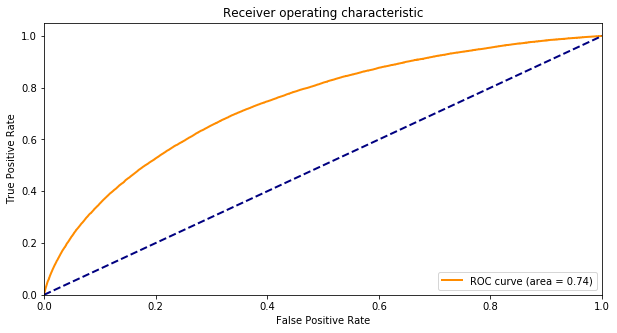

In [131]:
fpr, tpr, thresholds = roc_curve(y, score)

plt.figure(figsize = (10,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y, score))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

На тестовой выборке данная модель дает **ROC_AUC = 0.724**

Можно сделать выводы:
1. Переобучения не случилось
2. Снижение результата на тесте, вероятно, вызвано смещением данных в тестовой выборке, и/или не оптимальным биннингом

#### Обсуждение

Пройдемся по итоговому списку переменных, вошедших к нам в модель. От самых важных до менее важных:

**1. Внешние скоринг-оценки** (IV = 0.32, 0.30, 0.11)

Ничего удивительного, что внешние источники данных о качестве заемщика, дают наибольший прирост разделяющей способности.
Клиенты с наименьшим значением скоринга, чаще выходят в дефолт (за исключением нулевого бина - там где нет данных, стоят нули

In [139]:
print(app_data_total.groupby('app_EXT_SOURCE_3')['app_TARGET'].mean())
print('\n')
print(app_data_total.groupby('app_EXT_SOURCE_2')['app_TARGET'].mean())
print('\n')
print(app_data_total.groupby('app_EXT_SOURCE_1')['app_TARGET'].mean())

app_EXT_SOURCE_3
(-0.001, 0.000527]                   0.09
(0.000527, 0.259]                    0.19
(0.259, 0.372]                       0.11
(0.372, 0.46]                        0.08
(0.46, 0.537]                        0.06
(0.537, 0.604]                       0.05
(0.604, 0.669]                       0.05
(0.669, 0.735]                       0.04
(0.735, 0.896]                       0.03
Name: app_TARGET, dtype: float64


app_EXT_SOURCE_2
(-0.001, 0.212]                   0.18
(0.212, 0.338]                    0.12
(0.338, 0.439]                    0.10
(0.439, 0.511]                    0.08
(0.511, 0.565]                    0.07
(0.565, 0.608]                    0.07
(0.608, 0.646]                    0.06
(0.646, 0.682]                    0.05
(0.682, 0.722]                    0.04
(0.722, 0.855]                    0.03
Name: app_TARGET, dtype: float64


app_EXT_SOURCE_1
(-0.001, 0.196]                   0.09
(0.196, 0.378]                    0.11
(0.378, 0.534]                   

**2. Стаж на последнем месте работы** (IV = 0.10)
    
Интуитивно понятная переменная, чем дольше клиент работает на одном месте - тем стабильнее у него доход

In [141]:
# дни указаны от даты заявки, то есть чем меньше число - тем старше
print(app_data_total.groupby('app_DAYS_EMPLOYED')['app_TARGET'].mean())

app_DAYS_EMPLOYED
(-17912.001, -4881.0]                   0.05
(-4881.0, -3231.0]                      0.06
(-3231.0, -2362.0]                      0.07
(-2362.0, -1695.0]                      0.08
(-1695.0, -1213.0]                      0.10
(-1213.0, -822.0]                       0.10
(-822.0, -458.0]                        0.11
(-458.0, -144.0]                        0.11
(-144.0, 365243.0]                      0.06
Name: app_TARGET, dtype: float64


**3. Цена товара для которого берется кредит** (IV = 0.09)

Не слишком очевидная находка, похоже что здесь нелинейная зависимость. Такие зависимости лог-регрессия не ловит, поэтому здесь есть место дополнительной аналитике. Потенциал для улучшения модели

In [144]:
print(app_data_total.groupby('app_AMT_GOODS_PRICE')['app_TARGET'].mean())

app_AMT_GOODS_PRICE
(-0.001, 180000.0]                       0.07
(180000.0, 225000.0]                     0.09
(225000.0, 270000.0]                     0.08
(270000.0, 373500.0]                     0.10
(373500.0, 450000.0]                     0.13
(450000.0, 522000.0]                     0.07
(522000.0, 675000.0]                     0.08
(675000.0, 814500.0]                     0.06
(814500.0, 1093500.0]                    0.07
(1093500.0, 4050000.0]                   0.05
Name: app_TARGET, dtype: float64


**4. Возраст клиента** (IV = 0.08)

Самая понятная переменная - чем старше клиент, тем меньше вероятность невозврата

In [145]:
print(app_data_total.groupby('app_DAYS_BIRTH')['app_TARGET'].mean())

app_DAYS_BIRTH
(-25229.001, -22181.0]                   0.05
(-22181.0, -20474.0]                     0.05
(-20474.0, -18885.0]                     0.06
(-18885.0, -17220.0]                     0.07
(-17220.0, -15750.0]                     0.08
(-15750.0, -14416.0]                     0.08
(-14416.0, -13140.0]                     0.09
(-13140.0, -11694.0]                     0.10
(-11694.0, -10284.0]                     0.11
(-10284.0, -7489.0]                      0.12
Name: app_TARGET, dtype: float64


**5. Число дней с открытия первого/последнего кредита** (IV = 0.08/0.07)

Чем свежее кредиты у клиента в КИ, тем хуже

In [146]:
print(app_data_total.groupby('b_last_credit_days')['app_TARGET'].mean())
print('\n')
print(app_data_total.groupby('b_first_credit_days')['app_TARGET'].mean())

b_last_credit_days
(-2922.001, -1076.0]                   0.06
(-1076.0, -658.0]                      0.05
(-658.0, -448.0]                       0.06
(-448.0, -328.0]                       0.06
(-328.0, -239.0]                       0.07
(-239.0, -171.0]                       0.09
(-171.0, -109.0]                       0.09
(-109.0, -48.0]                        0.10
(-48.0, 0.0]                           0.11
Name: app_TARGET, dtype: float64


b_first_credit_days
(-2922.001, -2786.0]                   0.06
(-2786.0, -2610.0]                     0.06
(-2610.0, -2391.0]                     0.06
(-2391.0, -1963.0]                     0.06
(-1963.0, -1544.0]                     0.07
(-1544.0, -1188.0]                     0.08
(-1188.0, -802.0]                      0.09
(-802.0, -366.0]                       0.10
(-366.0, 0.0]                          0.11
Name: app_TARGET, dtype: float64


**6. Отношение суммы товара для кредита к сумме кредита** (IV = 0.07)

Не слишком очевидная находка, но в целом логичная - чем больший кредит берет клиент (по отношению к минимально необходимому, тем больше вероятность невыплаты)

In [147]:
print(app_data_total.groupby('m_CREDIT_TO_GOOD')['app_TARGET'].mean())

m_CREDIT_TO_GOOD
(-0.001, 0.783]                   0.13
(0.783, 0.826]                    0.11
(0.826, 0.854]                    0.09
(0.854, 0.873]                    0.08
(0.873, 0.894]                    0.07
(0.894, 0.927]                    0.07
(0.927, 1.0]                      0.07
(1.0, 6.667]                      0.05
Name: app_TARGET, dtype: float64


**7. Доля остатка задолженности** (IV = 0.06)

Все просто - чем больше у клиента долговая нагрузка (невыплаченных долгов), тем выше вероятность невозврата следующего кредита

In [158]:
print(app_data_total.groupby('b_debt_ratio')['app_TARGET'].mean())

b_debt_ratio
(-inf, 0.0]                        0.07
(0.0, 0.000726]                    0.07
(0.000726, 0.12]                   0.06
(0.12, 0.242]                      0.07
(0.242, 0.366]                     0.07
(0.366, 0.504]                     0.09
(0.504, 0.69]                      0.10
(0.69, 7.789]                      0.13
Name: app_TARGET, dtype: float64


**8. Категория должности** (IV = 0.06)

Низкоквалифицированные рабочие показывают более плохое качество. Это может быть связано с тем, что у них низкие доходы, но наша модель предпочла эту переменную переменной "доход"

In [159]:
print(app_data_total.groupby('app_OCCUPATION_TYPE')['app_TARGET'].mean())

app_OCCUPATION_TYPE
Core staff                              0.06
Drivers                                 0.11
High skill tech staff                   0.06
Laborers                                0.11
Managers                                0.06
N/A                                     0.07
Other                                   0.08
Sales staff                             0.10
Name: app_TARGET, dtype: float64


**9. Доля активных кредитов** (IV = 0.06)

Еще один показатель высокой кредитной нагрузки - чем больше доля открытых кредитов, тем хуже

In [152]:
print(app_data_total.groupby('m_active_credit_part')['app_TARGET'].mean())

m_active_credit_part
(-0.001, 0.1]                   0.08
(0.1, 0.25]                     0.05
(0.25, 0.333]                   0.06
(0.333, 0.4]                    0.08
(0.4, 0.5]                      0.08
(0.5, 0.6]                      0.10
(0.6, 1.0]                      0.11
Name: app_TARGET, dtype: float64


**10. Тип дохода** (IV = 0.06)

Госслужащие и пенсионеры менее склонны выходить в дефолт. Интересное наблюдение, не факт, что для России оно будет справедливо

In [160]:
print(app_data_total.groupby('app_NAME_INCOME_TYPE')['app_TARGET'].mean())

app_NAME_INCOME_TYPE
Commercial associate                   0.07
Pensioner                              0.05
State servant                          0.06
Working                                0.10
Name: app_TARGET, dtype: float64


**11. Рейтинг региона** (IV = 0.05)

Внутренний рейтинг регионов банка Home Credit. Хоть и нет понимания работы рейтинга, но он неплохо разделяет плохих клиентов от хороших

In [156]:
print(app_data_total.groupby('app_REGION_RATING_CLIENT_W_CITY')['app_TARGET'].mean())

app_REGION_RATING_CLIENT_W_CITY
1                   0.05
2                   0.08
3                   0.11
Name: app_TARGET, dtype: float64


### Итог
В целом, модель смотрится адекватной. В реальной жизни следует обратить внимание на следующие моменты:
* Среди переменных не отобралось ни одной переменной, характеризующих частоту и размеры выхода в просрочку. Скорее всего, причина неотбора в том, что случаев выхода в просрочку в обучающей выборке достаточно мало, что понижает IV.
* Не отобралось ни одной переменной из предыдущей заявки. Например, предыдущее решение по заявке может дать прирост к GINI, и, что более важно, оно слабо связано с переменными другого типа
* Переменная "цена целевого товара" должна быть пересмотрена, либо заменена, т.к. не несет в себе объяснимой логики

### LGBMClassifier

Попробуем более мощный классификатор, основанный на градиентном бустинге

Не будем отбирать и преобразовывать переменные, возьмем как есть. За исключением категориальных - для них возьмем соответствующие woe-значения

In [104]:
obj_col_woe = ['app_NAME_INCOME_TYPE_woe', 'app_OCCUPATION_TYPE_woe']
final_cols = pd.Series(final_cols).str.replace('_woe', '').values
num_col = app_data_total[list(set(list(num_1_cols) + list(num_2_cols)).intersection(set(final_cols)))].select_dtypes(exclude = 'object').columns + '_as_is'
#num_col = app_data_total[list(set(list(num_1_cols + '_woe') + list(num_2_cols + '_woe')).intersection(set(final_cols)))].select_dtypes(exclude = 'object').columns

other_cols = list(set(final_cols) - set(num_1_cols) - set(num_2_cols) - set(app_data_woe[final_cols].select_dtypes(include = 'object').columns))

X = pd.concat([app_data_woe[list(obj_col_woe)], app_data_total[list(num_col)], app_data_total[other_cols]], axis = 1).replace(-np.inf, 0)
y = app_data_total['app_TARGET'].to_numpy()

In [105]:
from lightgbm import LGBMClassifier
clf = LGBMClassifier(random_state=0).fit(X, y)

score = clf.predict_proba(X)[:, 1]
print(roc_auc_score(y, score))

0.7810360334258333


Результат значительно лучше. Однако, на тестовой выборке он ухудшается гораздо сильнее логистической регрессии (0.78 -> 0.74), что говорит о переобучении модели. Но даже переобученный LGB работает лучше логистической регрессии, хоть и не намного. 

Различные эксперименты показали следующие результаты:

1. LogReg на 14 переменных (IV >= 0.05): TRAIN: 0.738, TEST: 0.724
2. LogReg на 44 переменных (IV >= 0.03): TRAIN: 0.749, TEST: 0.738
3. LGBM на всех переменных: TRAIN: 0.781, TEST: 0.746

Можно сделать вывод, что в текущих условиях преимущество более сложной модели неочевидно. 
Имеет смысл более глубоко посмотреть на переменные, кажется, что доп value находится именно в них.
Также кажется, что сложные модели в данной задаче не дадут прирост ROC_AUC более 0.01-0.02. Для соревнования, это конечно, существенно, но для реальной жизни не особо. 

##### Для информации: лучший результат на Kaggle по этому соревнованию - 0.8